<a href="https://colab.research.google.com/github/zemerov/VAE/blob/main/ImageAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Our plan:

1) Prepare dataset with MNIST

2) Define VAE class

3) Teach models

4) Visualize latent space. Note: this space contains gaussian distributions.

I used VAE because it has more reliable latent space compare to naive autoencoder.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchvision.utils as vutils
import tqdm

import matplotlib.pyplot as plt
import numpy as np

In [349]:
batch_size = 512

In [350]:
#%%capture

def get_loader(train, batch_size):
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train_loader = get_loader(True, batch_size)
val_loader = get_loader(False, batch_size)

## Model

In [234]:
class Squeezer(nn.Module):
    def __init__(self, add_dims=False):
        super().__init__()
        self.add_dims=add_dims
    
    def forward(self, x):
        if self.add_dims:
            return x.unsqueeze(2).unsqueeze(3)
        else:
            return x.squeeze(2).squeeze(2)

In [383]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=64, device='cpu'):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 8, 14, padding=0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 16, 8, padding=0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 64, 8, padding=0),
            nn.LeakyReLU(0.2),
            Squeezer(add_dims=False),
            nn.Linear(64, h_dim)
        )
        
        self.h2mu = nn.Linear(h_dim, h_dim)  # Mean
        self.h2sigma = nn.Linear(h_dim, h_dim)  # Varience
        
        self.decoder = nn.Sequential(
            nn.Linear(h_dim, 64),
            Squeezer(add_dims=True),
            nn.ConvTranspose2d(64, 16, 8, padding=0),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 8, 8, padding=0),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(8, image_channels, 14, padding=0),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()
        )

        self.device = device
        self.h_dim = h_dim
        
    def sample(self, mu: torch.FloatTensor, logvar: torch.FloatTensor):
        """
        Get parameters for gaussian distribution and smaple random viraibles 
        using reparametrization.

        :param mu: tensor of shape [batch_size, z_dim] contains means
        :param logvar: tensor of shape [batch_size, z_dim] contains log variances

        :return z: tensor of shape [batch_size, z_sim]

        """
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size()).to(self.device)
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.sample(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        # это можно использовать для морфинга, например
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        # For MNIST 1x28x28
        h = self.encoder(x)  # [batch_size, 64, 1, 1]
        #h = h.squeeze(2).squeeze(2) # [batch_size, 64]
        z, mu, logvar = self.bottleneck(h)
        #z = z.unsqueeze(2).unsqueeze(3) # [batch_size, 64, 1, 1]
        return self.decoder(z), mu, logvar
    
    def generate(self, size=1):
        noise = torch.randn([1, self.h_dim]).to(self.device)

        with torch.no_grad():
            images = model.decode(noise).squeeze(0).squeeze(0).cpu().numpy()
        
        return images

In [270]:
def vae_loss(recon_x, x, mu, logvar, kl_coeff=0.5):
    BCE = F.binary_cross_entropy(recon_x.view(-1), x.view(-1), reduction='sum')
    KLD = -kl_coeff * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD  # Перед KLD можно менять параметр

## Training

In [351]:
def train(model, optimizer, train_loader, device=device, num_epochs=10):
    train_losses = []

    for epoch in range(num_epochs):
        pbar = tqdm.notebook.tqdm_notebook(
            train_loader, 
            desc="Train loss {}.".format(0)
            )
    
        for data, _ in pbar:
            data = data.to(device)
        
            optimizer.zero_grad()
        
            recon_batch, mu, logvar = model(data)
        
            loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()

            train_losses.append(loss.item())
        
            optimizer.step()

            pbar.set_description("Train loss {:.3f}.".format(loss.item()))
    return train_losses

In [384]:
device = 'cuda'

model = VAE(image_channels=1, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [385]:
train_losses = train(model, optimizer, train_loader, num_epochs=10)

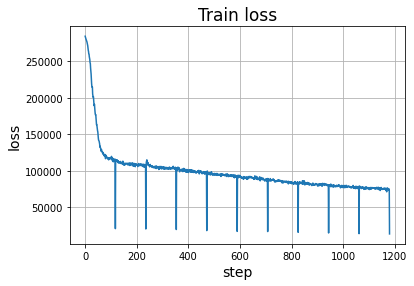

In [388]:
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title("Train loss", fontsize=17)
plt.xlabel("step", fontsize=14)
plt.ylabel("loss", fontsize=14)
#plt.ylim([85000, 95000])
plt.grid()
plt.show()

### Lets generate some images using decoder.

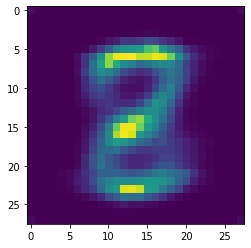

In [398]:
plt.imshow(
    model.generate()
    )

plt.show()

Looks almost like an original image!

## Latent space visualization

### Utilities

In [336]:
def get_points(model, loader):
    stds = []
    means = []
    labels = []
    
    with torch.no_grad():
        for data, label in val_loader:
            data = data.to(device)

            _, mu, logvar = model.bottleneck(model.encoder(data))
            std = logvar.exp()**(1/2)
            means.append(mu.cpu().numpy())
            stds.append(std.cpu().numpy())
            labels.append(label.cpu().numpy())

    means = np.concatenate(means)
    stds = np.concatenate(stds)
    labels = np.concatenate(labels)

    return means, stds, labels

In [345]:
colors = {
        1 : 'lightpink', 
        2: 'green', 
        3: 'blue', 
        4 : 'orange',
        5 : 'yellow',
        6 : 'magenta',
        7 : 'black', 
        8 : 'cyan',
        9 : 'crimson', 
        0 : 'wheat'
    }

def visualize(points, labels):
    X = points[:, 0]
    Y = points[:, 1]
    
    plt.figure(figsize=(11,6))
    plt.scatter(X, Y, s=12, alpha=0.4, color=list(map(lambda x: colors[x], labels)))
    plt.grid()
    plt.show()

### Visualize high-dimensional latent space with PCA

Lets try to learn VAE with high-dimensional latent space and then decompose it to 2-dim.

Disclaimer: But for the fact that we have distribution after encoding we cannot plot only projections of initial points. Perfect visualization should include std on the plots but i will plot only means. It will be enough for fascinating plots :)

In [338]:
from sklearn.decomposition import PCA

In [364]:
means, _, lbl = get_points(model, val_loader)

In [365]:
decompose = PCA(n_components=2)
points = decompose.fit_transform(means)

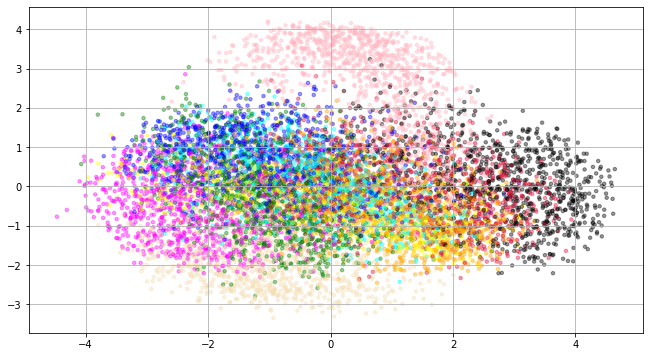

In [366]:
visualize(points, lbl)

Not really good latent space. Maybe because PCA reduction is not really useful in this case. Lets make better!

### Visualize with 2-dimensional latent space

In [372]:
model = VAE(image_channels=1, device=device, h_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses = train(model, optimizer, train_loader, num_epochs=10)

In [373]:
means, _, lbl = get_points(model, val_loader)

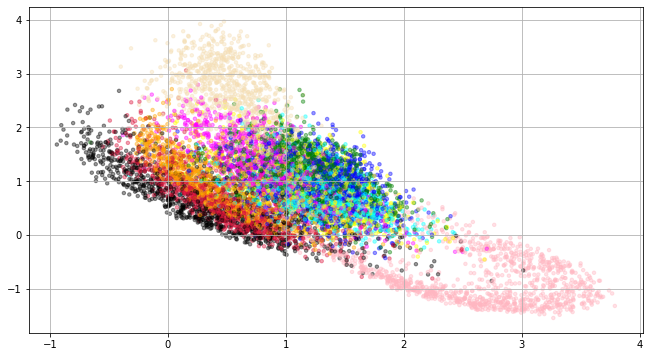

In [374]:
visualize(means, lbl)

### Conclusion

It is clearly noticable that distribution of VAE with 2-dim hidden state is distinct for differrent classes. Futhermore there is almost continous latant space, which is really useful for image generation.